# **04. 다중회귀분석**

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import bartlett
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.ticker as ticker
import seaborn as sns
import scipy as sp
from scipy import stats
import ast
from datetime import datetime, date, timedelta
from pandas.tseries.offsets import DateOffset
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings("ignore")

font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams['font.family'] = font_family
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

In [2]:
apartment = pd.read_csv("apartment_20230910.csv")
apartment = apartment.copy()
apartment.drop(columns=['아파트명', '임대세대수', '법정동주소', '위도', '경도', '지하철역', '역사명', '현관구조'], axis=1, inplace=True)
apartment = apartment.dropna() # 한 컬럼이라도 결측치가 있다면 행을 삭제

In [3]:
dummy_columns = ['광역', '기초', '입주예정연도', '노선명_리스트', '투기과열지구_after', '분양가상한제_after', '투기과열지구_before', '분양가상한제_before']

continuous_columns = [column for column in apartment.columns if column not in dummy_columns and apartment[column].dtype in ['int64', 'float64']]
categorical_columns = [column for column in apartment.columns if column not in dummy_columns and apartment[column].dtype in ['object', 'bool']]

**연속형 변수의 정규성 검정**

In [4]:
for variable in continuous_columns:
    statistic, p_value = stats.shapiro(apartment[variable])
    
    alpha = 0.05
    if p_value >= alpha:
        print(f"Shapiro-Wilk Test 결과 {variable} 변수는 정규성 가정을 충족하지 못함: Statistic: {statistic}, p-value: {p_value}")

**상관관계 분석**

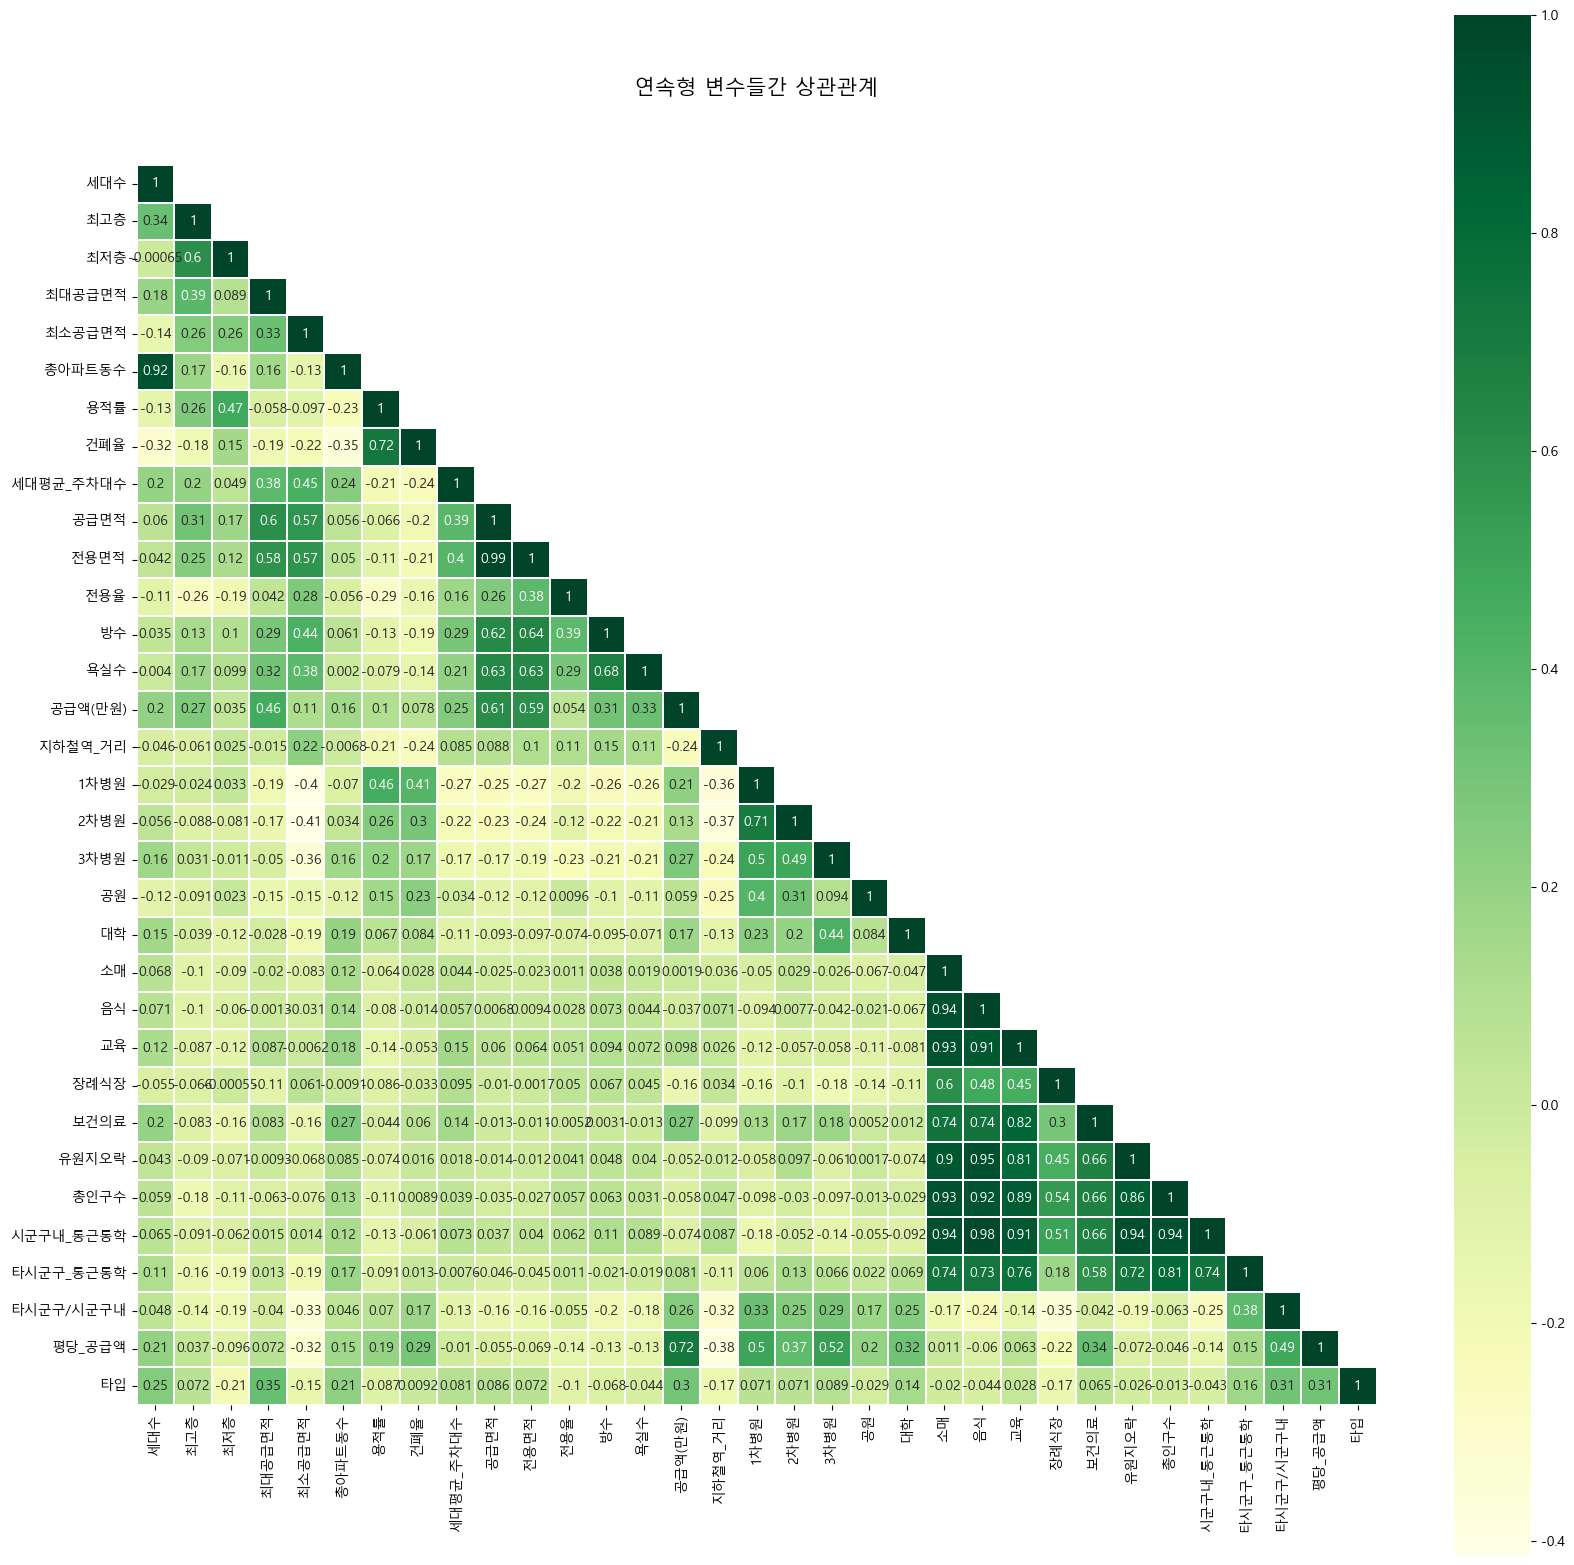

In [5]:
corr_df = apartment[continuous_columns].corr()

colormap = plt.cm.YlGn

plt.figure(figsize=(20, 20))
plt.title("연속형 변수들간 상관관계", y = 1.05, size = 15, color='black')

mask = np.array(corr_df)
mask[np.tril_indices_from(mask)] = False

sns.heatmap(corr_df, linewidths=0.1, vmax=1.0, cmap=colormap, mask=mask,
            square=True, annot=True)

plt.xticks()
plt.yticks() 

plt.show() 

**범주형 변수인 '대형건설사' 컬럼과 공급액 간 관계 독립표본 T-test**   

In [6]:
big = apartment[apartment['대형건설사'] == True]['공급액(만원)']
small = apartment[apartment['대형건설사'] == False]['공급액(만원)']

t_statistic, p_value = ttest_ind(big, small)

print("t-통계량 (t-statistic):", t_statistic)
print("p-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("대형건설사 여부에 따른 공급액의 평균 차이는 통계적으로 유의미합니다.")
else:
    print("대형건설사 여부에 따른 공급액의 평균 차이는 통계적으로 유의미하지 않습니다.")

t-통계량 (t-statistic): 19.805513746724305
p-value: 7.121088997309664e-82
대형건설사 여부에 따른 공급액의 평균 차이는 통계적으로 유의미합니다.


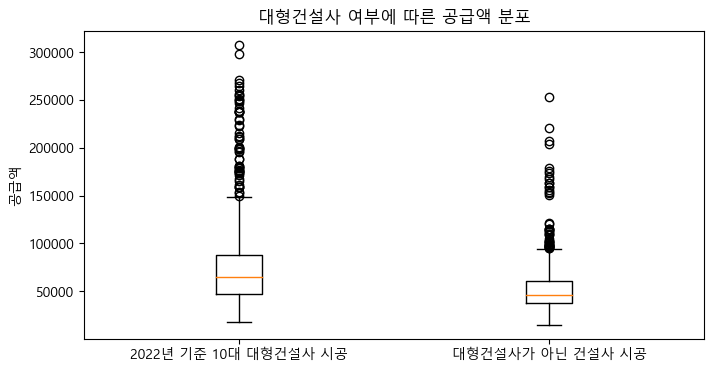

In [7]:
plt.figure(figsize=(8, 4))
plt.boxplot([big, small], labels=['2022년 기준 10대 대형건설사 시공', '대형건설사가 아닌 건설사 시공'])
plt.title("대형건설사 여부에 따른 공급액 분포")
plt.ylabel("공급액")
plt.show()

**더미변수화**

In [8]:
apartment['기초'] = apartment['광역']+'_'+apartment['기초']
apartment = pd.get_dummies(apartment, columns=['광역', '기초', '입주예정연도'])

unique_routes = [route for sublist in apartment['노선명_리스트'] for route in ast.literal_eval(sublist)]
unique_routes = list(set(unique_routes))
for route in unique_routes:
    column_name = f'노선_{route}'
    apartment[column_name] = apartment['노선명_리스트'].apply(lambda x: 1 if route in x else 0)
    
apartment.drop(columns=['노선명_리스트'], axis=1, inplace=True)

**더미변수 분석**

In [9]:
seoul = apartment[apartment['광역_서울'] == 1]['공급액(만원)']
incheon = apartment[apartment['광역_인천'] == 1]['공급액(만원)']
gyeonggi = apartment[apartment['광역_경기'] == 1]['공급액(만원)']

bartlett_result = stats.bartlett(seoul, incheon, gyeonggi)
print("Bartlett Test p-value:", bartlett_result.pvalue) 

if p_value < 0.05:
    print("등분산성 가정을 만족하지 않습니다.")
else:
    print("등분산성 가정을 만족합니다.")
    
f_statistic, p_value = stats.f_oneway(seoul, incheon, gyeonggi)

print("\nWelch's ANOVA F-statistic:", f_statistic)
print("Welch's ANOVA p-value:", p_value)

if p_value < 0.05:
    print("지역 간 공급액의 평균 차이는 통계적으로 유의미합니다.")
else:
    print("지역 간 공급액의 평균 차이는 통계적으로 유의미하지 않습니다.")

Bartlett Test p-value: 1.5505892617277091e-117
등분산성 가정을 만족하지 않습니다.

Welch's ANOVA F-statistic: 185.2135560886753
Welch's ANOVA p-value: 2.5159118810323554e-76
지역 간 공급액의 평균 차이는 통계적으로 유의미합니다.


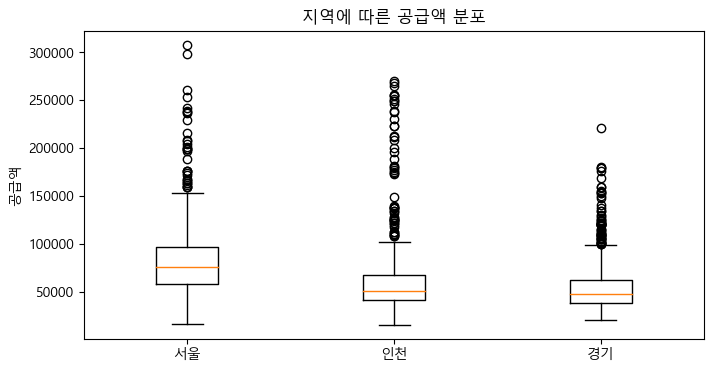

In [10]:
plt.figure(figsize=(8, 4))
plt.boxplot([seoul, incheon, gyeonggi], labels=['서울', '인천', '경기'])
plt.title("지역에 따른 공급액 분포")
plt.ylabel("공급액")
plt.show()

In [11]:
before_2023 = apartment[
    (apartment['입주예정연도_2020'] == 1) |
    (apartment['입주예정연도_2021'] == 1) |
    (apartment['입주예정연도_2022'] == 1) |
    (apartment['입주예정연도_2023'] == 1)]["공급액(만원)"]
in_2024 = apartment[apartment['입주예정연도_2024'] == 1]["공급액(만원)"]
in_2025 = apartment[apartment['입주예정연도_2025'] == 1]["공급액(만원)"]
after_2026 = apartment[(apartment['입주예정연도_2026'] == 1) | (apartment['입주예정연도_2027'] == 1)]["공급액(만원)"]

bartlett_result = stats.bartlett(before_2023, in_2024, in_2025, after_2026)
print("Bartlett Test p-value:", bartlett_result.pvalue)
if p_value < 0.05:
    print("등분산성 가정을 만족하지 않습니다.")
else:
    print("등분산성 가정을 만족합니다.")
    
f_statistic, p_value = stats.f_oneway(before_2023, in_2024, in_2025, after_2026)

print("\nWelch's ANOVA F-statistic:", f_statistic)
print("Welch's ANOVA p-value:", p_value)

if p_value < 0.05:
    print("입주예정연도별 공급액의 평균 차이는 통계적으로 유의미합니다.")
else:
   print("입주예정연도별 아파트의 평균 차이는 통계적으로 유의미하지 않습니다.")

Bartlett Test p-value: 5.513782873746562e-31
등분산성 가정을 만족하지 않습니다.

Welch's ANOVA F-statistic: 38.913877131278134
Welch's ANOVA p-value: 1.226498179792275e-24
입주예정연도별 공급액의 평균 차이는 통계적으로 유의미합니다.


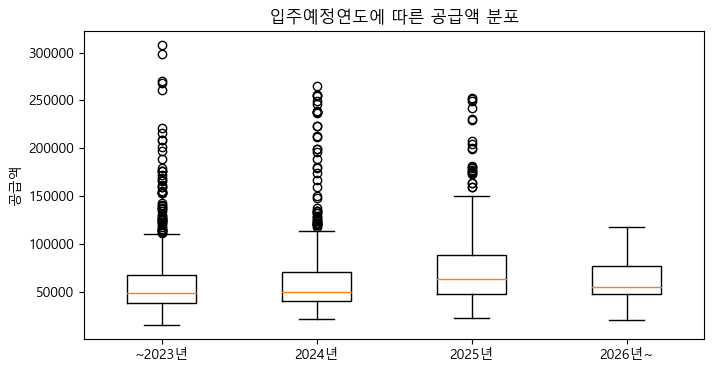

In [12]:
plt.figure(figsize=(8, 4))
plt.boxplot([before_2023, in_2024, in_2025, after_2026], labels=['~2023년', '2024년', '2025년', '2026년~'])
plt.title("입주예정연도에 따른 공급액 분포")
plt.ylabel("공급액")
plt.show()

In [13]:
apartment.rename(columns={'공급액(만원)': '공급액',
                           '1차병원': '병원_1차',
                           '2차병원': '병원_2차',
                           '3차병원': '병원_3차',
                           '노선_인천지하철 1호선': '노선_인천_1호선',
                           '노선_인천지하철 2호선': '노선_인천_2호선',
                           '타시군구/시군구내': '타시군구_시군구내'}, inplace=True)
variable_list = list(apartment.columns)
apartment.to_csv("regression_data.csv", index=False)

In [14]:
'+'.join(variable_list)

'세대수+최고층+최저층+최대공급면적+최소공급면적+총아파트동수+용적률+건폐율+세대평균_주차대수+공급면적+전용면적+전용율+방수+욕실수+공급액+대형건설사+지하철역_거리+병원_1차+병원_2차+병원_3차+공원+대학+소매+음식+교육+장례식장+보건의료+유원지오락+총인구수+투기과열지구_after+분양가상한제_after+투기과열지구_before+분양가상한제_before+시군구내_통근통학+타시군구_통근통학+타시군구_시군구내+평당_공급액+타입+광역_경기+광역_서울+광역_인천+기초_경기_가평군+기초_경기_고양시+기초_경기_과천시+기초_경기_광명시+기초_경기_광주시+기초_경기_구리시+기초_경기_군포시+기초_경기_김포시+기초_경기_남양주시+기초_경기_동두천시+기초_경기_부천시+기초_경기_성남시+기초_경기_수원시+기초_경기_시흥시+기초_경기_안산시+기초_경기_안성시+기초_경기_안양시+기초_경기_양주시+기초_경기_양평군+기초_경기_여주시+기초_경기_연천군+기초_경기_오산시+기초_경기_용인시+기초_경기_의왕시+기초_경기_의정부시+기초_경기_이천시+기초_경기_파주시+기초_경기_평택시+기초_경기_포천시+기초_경기_하남시+기초_경기_화성시+기초_서울_강남구+기초_서울_강동구+기초_서울_강북구+기초_서울_강서구+기초_서울_관악구+기초_서울_광진구+기초_서울_구로구+기초_서울_금천구+기초_서울_노원구+기초_서울_도봉구+기초_서울_동대문구+기초_서울_동작구+기초_서울_서대문구+기초_서울_서초구+기초_서울_성동구+기초_서울_성북구+기초_서울_송파구+기초_서울_양천구+기초_서울_영등포구+기초_서울_용산구+기초_서울_은평구+기초_서울_종로구+기초_서울_중구+기초_서울_중랑구+기초_인천_강화군+기초_인천_계양구+기초_인천_남동구+기초_인천_동구+기초_인천_미추홀구+기초_인천_부평구+기초_인천_서구+기초_인천_연수구+기초_인천_중구+입주예정연도_2020+입주예정연도_2021+입주예정연도_2022+입주예정연도_2023+입주예정연도_2024+입주예정연도_2025+입주예정연도_2026+입주예정연도_2027+노선_신

### **공급액을 종속변수로 하는 회귀분석**

In [15]:
formula = '공급액 ~ 세대수+최소공급면적+총아파트동수+용적률+건폐율+세대평균_주차대수+공급면적+욕실수+대형건설사+지하철역_거리+\
                    병원_1차+공원+대학+소매+투기과열지구_before+분양가상한제_before+\
                    타시군구_시군구내+타입+노선_2호선+노선_4호선+노선_5호선+노선_7호선+노선_9호선+\
                    노선_분당선+노선_신분당선+노선_인천국제공항선+노선_인천_1호선+노선_인천국제공항선+입주예정연도_2025+입주예정연도_2026+광역_서울+광역_인천+기초_서울_용산구+기초_서울_강남구+기초_서울_서초구+기초_서울_노원구+\
                    기초_서울_광진구+기초_서울_구로구+기초_서울_금천구+기초_서울_은평구+기초_경기_고양시+기초_경기_과천시+기초_경기_광명시+기초_경기_성남시+기초_경기_하남시+기초_경기_화성시\
                    '
model = smf.ols(formula, apartment)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    공급액   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     314.9
Date:                Fri, 20 Oct 2023   Prob (F-statistic):               0.00
Time:                        15:57:24   Log-Likelihood:                -31035.
No. Observations:                2838   AIC:                         6.216e+04
Df Residuals:                    2792   BIC:                         6.243e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -5.247e+04   2

In [16]:
pd.set_option('display.max_columns', None)

df = pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(result.model.exog, i)}
              for i, column in enumerate(result.model.exog_names)
              if column != 'Intercept')
df.sort_values(by='VIF')

,컬럼,VIF
11,기초_서울_금천구[T.True],1.144112
2,입주예정연도_2026[T.True],1.199569
5,기초_서울_용산구[T.True],1.211399
10,기초_서울_구로구[T.True],1.279767
8,기초_서울_노원구[T.True],1.292404
1,입주예정연도_2025[T.True],1.298261
9,기초_서울_광진구[T.True],1.350630
13,기초_경기_고양시[T.True],1.413016
16,기초_경기_성남시[T.True],1.431143
18,기초_경기_화성시[T.True],1.440037


**정규성 검정**

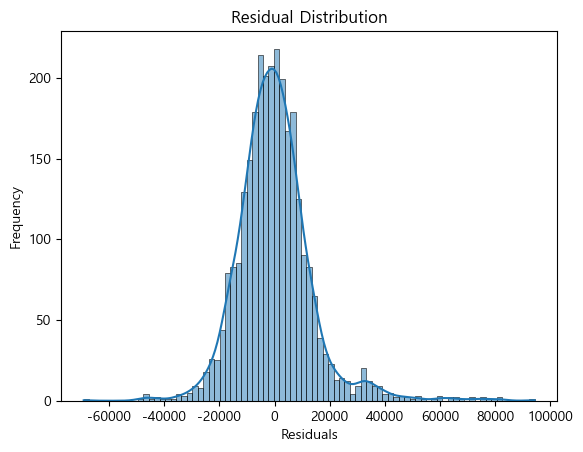

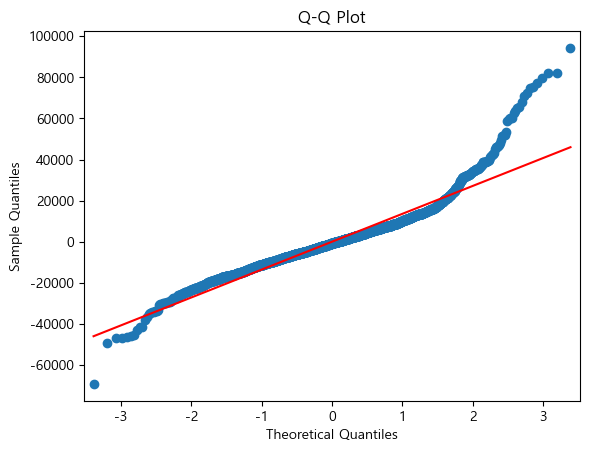

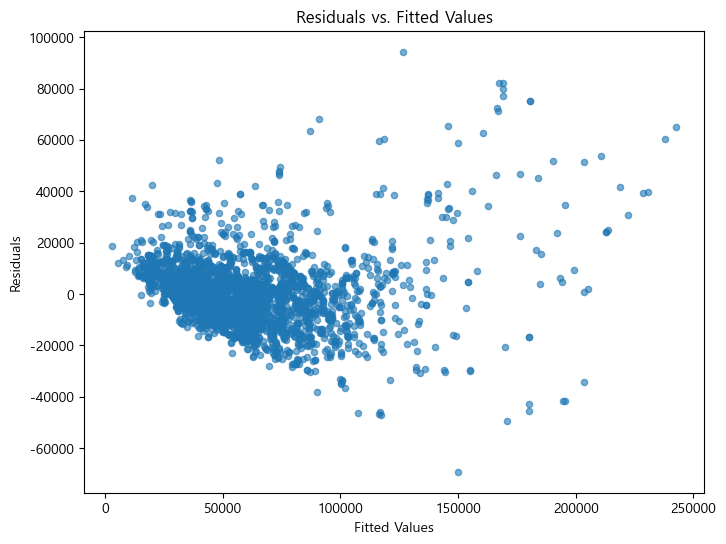

In [17]:
residuals = result.resid

# 잔차 히스토그램
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")

# Q-Q 플롯
sm.qqplot(residuals, line='s', color='b')
plt.title("Q-Q Plot")

# 잔차 대 예측값 (Residuals vs. Fitted) 플롯
plt.figure(figsize=(8, 6))
plt.scatter(result.fittedvalues, residuals, s=20, alpha=0.6)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")

plt.show()

In [18]:
output_filename = 'regression_sales_result_20230910.txt'
with open(output_filename, 'w') as f:
    f.write(result.summary().as_text())

### **평당 공급액을 종속변수로 하는 회귀분석**

In [19]:
formula = '평당_공급액 ~ 세대수+최소공급면적+총아파트동수+건폐율+세대평균_주차대수+욕실수+대형건설사+지하철역_거리+\
                    병원_1차+공원+대학+소매+투기과열지구_before+분양가상한제_before+\
                    타시군구_시군구내+타입+노선_2호선+노선_4호선+노선_5호선+노선_7호선+노선_9호선+\
                    노선_분당선+노선_신분당선+노선_인천_1호선+입주예정연도_2025+입주예정연도_2026+광역_서울+기초_서울_용산구+기초_서울_강남구+기초_서울_강북구+기초_서울_서초구+기초_서울_노원구+\
                    기초_서울_구로구+기초_서울_금천구+기초_서울_은평구+기초_경기_고양시+기초_경기_과천시+기초_경기_광명시+기초_경기_성남시+기초_경기_하남시+기초_경기_화성시\
                    +기초_인천_연수구'
model = smf.ols(formula, apartment)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 평당_공급액   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     263.0
Date:                Fri, 20 Oct 2023   Prob (F-statistic):               0.00
Time:                        15:57:27   Log-Likelihood:                -20782.
No. Observations:                2838   AIC:                         4.165e+04
Df Residuals:                    2795   BIC:                         4.191e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             633.3362    

**정규성 검정**

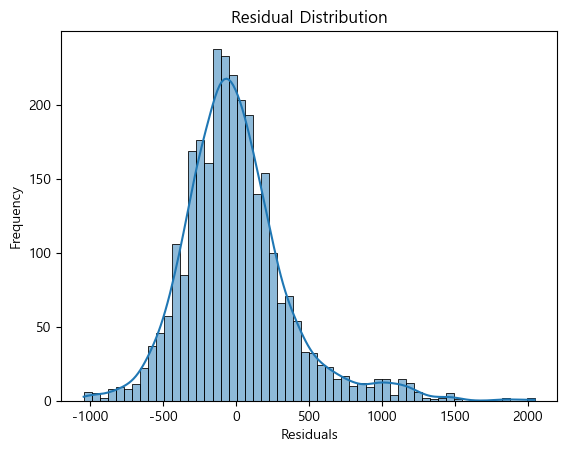

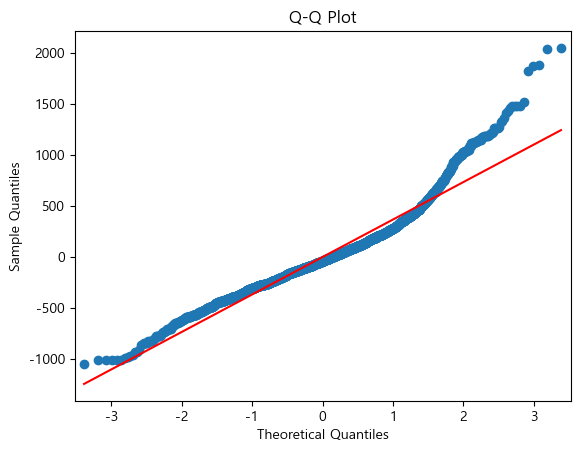

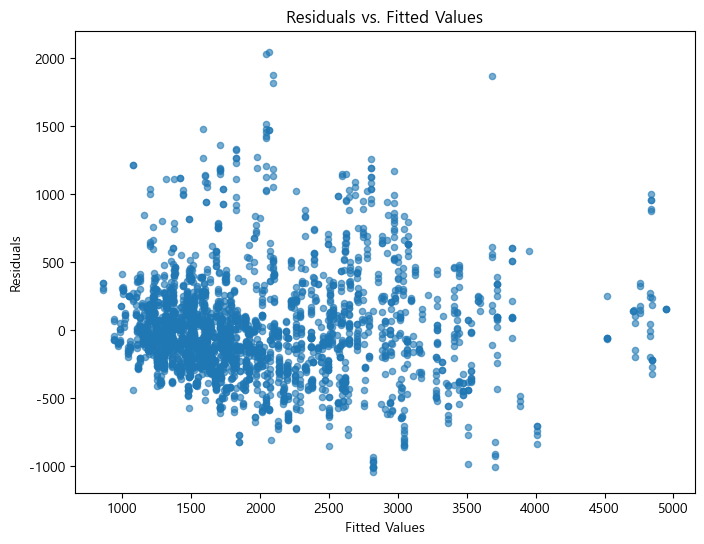

In [20]:
residuals = result.resid

# 잔차 히스토그램
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")

# Q-Q 플롯
sm.qqplot(residuals, line='s', color='b')
plt.title("Q-Q Plot")

# 잔차 대 예측값 (Residuals vs. Fitted) 플롯
plt.figure(figsize=(8, 6))
plt.scatter(result.fittedvalues, residuals, s=20, alpha=0.6)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")

plt.show()

In [21]:
pd.set_option('display.max_columns', None)

df = pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(result.model.exog, i)}
              for i, column in enumerate(result.model.exog_names)
              if column != 'Intercept')
df.sort_values(by='VIF')

,컬럼,VIF
4,기초_서울_용산구[T.True],1.153309
10,기초_서울_금천구[T.True],1.167208
2,입주예정연도_2026[T.True],1.171546
24,욕실수,1.263450
1,입주예정연도_2025[T.True],1.275762
8,기초_서울_노원구[T.True],1.282586
9,기초_서울_구로구[T.True],1.319820
15,기초_경기_성남시[T.True],1.345377
34,노선_2호선,1.395759
12,기초_경기_고양시[T.True],1.410582


In [22]:
output_filename = 'regression_sales_per_result_20230910.txt'
with open(output_filename, 'w') as f:
    f.write(result.summary().as_text())